# NLP Word2Vec CBOW Neural Net using PyTorch by Michael Dobroski 12/12/2021

In [1]:
import pandas as pd
import string
import Word2VecSupport

def clean_text(text):    
    x = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    x = x.lower().split() # lower case and split by whitespace to differentiate words
    return x

example_text = pd.read_csv('text.csv')
cleaned_text = example_text.Review[:100].apply(clean_text)

In [2]:
# create vocab
intermid = []
for i in range(len(cleaned_text)):
    for j in range(len(cleaned_text[i])):
        intermid.append(cleaned_text[i][j])
vocab = set(intermid)

# create word_to_index dictionary
vocab = list(vocab)

# create word2Vec from the supporting class
word2Vec = Word2VecSupport.Word2Vec(vocab)

In [3]:
# CBOW model class definition
import torch
import torch.nn as nn
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CBOW, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activate1 = nn.ReLU()
        self.activate2 = nn.LogSoftmax(dim = -1)
    def forward(self, inputs):
        step = sum(self.embed(inputs)).view(1,-1)
        step = self.fc1(step)
        step = self.activate1(step)
        step = self.fc2(step)
        output = self.activate2(step)
        return output

In [4]:
# parameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
WINDOW_SIZE = 2
HIDDEN_DIM = 30
N_EPOCHS = 300

# pre-process data
data = word2Vec.createTupleList(cleaned_text, WINDOW_SIZE, word2Vec.word_to_index_dictionary)

# train CBOW model and update user
model = CBOW(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss = {}
print('Now training...')
for epoch in range(N_EPOCHS):
    currLoss = 0
    for slice in data:
        context, focus = slice
        logProb = model(context)
        currLoss += lossFunc(logProb, focus)
    if epoch % 10 == 0:
        print('Epoch {} - loss = {}'.format(epoch, round(float(currLoss), 3)))
    loss[epoch] = currLoss
    opt.zero_grad()
    currLoss.backward()
    opt.step()
print('{} epochs learned, final loss is {}'.format(N_EPOCHS, round(float(currLoss), 3)))

Now training...
Epoch 0 - loss = 4217.05
Epoch 10 - loss = 3374.741
Epoch 20 - loss = 2809.115
Epoch 30 - loss = 2281.403
Epoch 40 - loss = 1766.898
Epoch 50 - loss = 1238.338
Epoch 60 - loss = 736.606
Epoch 70 - loss = 593.156
Epoch 80 - loss = 295.511
Epoch 90 - loss = 159.768
Epoch 100 - loss = 111.298
Epoch 110 - loss = 83.485
Epoch 120 - loss = 65.807
Epoch 130 - loss = 53.748
Epoch 140 - loss = 45.111
Epoch 150 - loss = 38.685
Epoch 160 - loss = 33.742
Epoch 170 - loss = 29.835
Epoch 180 - loss = 26.679
Epoch 190 - loss = 24.079
Epoch 200 - loss = 21.91
Epoch 210 - loss = 20.071
Epoch 220 - loss = 18.497
Epoch 230 - loss = 17.135
Epoch 240 - loss = 15.947
Epoch 250 - loss = 14.903
Epoch 260 - loss = 13.978
Epoch 270 - loss = 13.154
Epoch 280 - loss = 12.416
Epoch 290 - loss = 11.75
300 epochs learned, final loss is 11.206


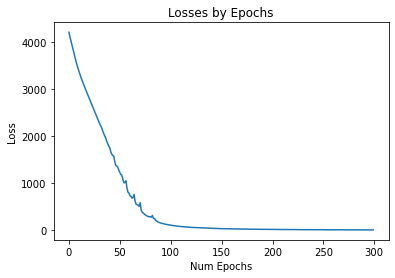

In [5]:
# plot losses vs epoch
import matplotlib.pyplot as plt
import numpy as np
x = np.array(list(loss.keys()))
y = np.zeros_like(x)
for i in range(N_EPOCHS):
    y[i] = loss[i]
_ = plt.plot(x, y)
_ = plt.xlabel("Num Epochs")
_ = plt.ylabel("Loss")
_ = plt.title("Losses by Epochs")

In [20]:
# using cosine similarity of embedded vectors of focus words, present user with the top five similar words to any target word according to recently trained model
import sklearn.metrics
embedding_weights = model.embed.weight.data
embedding_weights_dict = {}
cos_sim_dict = {}
target = vocab[117]
for i, word in enumerate(vocab):
    embedding_weights_dict[word] = embedding_weights[i].numpy()
for word in list(embedding_weights_dict.keys()):
    cos_sim_dict[word] = sklearn.metrics.pairwise.cosine_similarity(embedding_weights_dict[target].reshape(1, -1), embedding_weights_dict[word].reshape(1, -1))[0][0]
best_fits = sorted(cos_sim_dict.items(), key = lambda x : x[1], reverse = True)
print('The five most similar words to {} is ...'.format(target))
for i in range(1,6):
    word, sim = best_fits[i]
    print('{}. "{}" with cosine similarity value of {}'.format(i, word, round(float(sim), 4)))

The five most similar words to delicious is ...
1. "has" with cosine similarity value of 0.3196
2. "disgusted" with cosine similarity value of 0.2991
3. "today" with cosine similarity value of 0.274
4. "generic" with cosine similarity value of 0.2476
5. "year" with cosine similarity value of 0.2341
